# Example 2 - Using the IEA plugin

Futura is written to accept plugins (using the entry point `futura_plugin`). These can be written and installed separately to supplement and extend the features of Futura.

The first of these is the IEA plugin which automatically downloads the latest monthly OECD electricity generation statistics from the IEA and updates the high voltage grid mixes of the relevant countries\* accordingly. 

To run this example you'll need to install the IEA plugin. At the moment the best way to do this is using:

`pip install https://github.com/pjamesjoyce/futura_iea/archive/master.zip`

(It will get it's own PyPi and Conda release in due course)

In this example, we'll load ecoinvent 3.6 into a FuturaLoader, then use the IEA plugin to alter the grid mixes.

\*Note: The USA and Canada are excluded currently due to complications arising from sub-grids in ecoinvent

## Setting up
First we import all of the relevant things we need from Futura - note the plugin loads automatically when we import futura

In [4]:
import futura
from futura.loader import FuturaLoader
from futura.utils import create_filter_from_description
from futura import w
from futura.markets import FuturaMarket

We create a FuturaLoader, give it a simple recipe and run it. Note: as long as the `ecoinvent_version` and `ecoinvent_system_model` are set, you don't need to have an existing brightway project/database set up - you'll be prompted for your login details and it will create it for you

In [8]:
f = FuturaLoader()
f.recipe = {
    'metadata': {'base_project': 'Futura_SETUP',
                 'base_database': 'ecoinvent_cut-off36',
                 'output_database': 'ecoinvent_cut-off36_updated',
                 'ecoinvent_version': 3.6,
                 'ecoinvent_system_model': 'cut-off',
                 'description': 'blank version of ecoinvent 3.6'},
    'actions': [{'action': 'load',
                 'tasks': [{'function': 'extract_bw2_database',
                            'kwargs': {'project_name': 'Futura_SETUP',
                                       'database_name': 'ecoinvent_cut-off36'}}]
                }]
}
f.run()

load started
extract_bw2_database(project_name=Futura_SETUP, database_name=ecoinvent_cut-off36)
Getting activity data


  0%|                                                                                       | 0/615644 [00:00<?, ?it/s]

Adding exchange data to activities


100%|███████████████████████████████████████████████████████████████████████| 615644/615644 [00:39<00:00, 15778.96it/s]


Filling out exchange data


100%|██████████████████████████████████████████████████████████████████████████| 18121/18121 [00:03<00:00, 4878.09it/s]


WurstDatabase with 18121 items
FuturaDatabase with 18121 items
load finished


## Seeing where we start from

You can choose to update all of the locations at once, or specify a subset to use. Here we'll just do the UK and Germany.

In [50]:
grid_locations = ['DE', 'GB']

We'll write a filter to get our high voltage electricity markets, convert it into a wurst filter, and run it against the database in the FuturaLoader

In [52]:
elec_filter_base = [
            {'filter': 'equals', 'args': ['unit', 'kilowatt hour']},
            {'filter': 'startswith', 'args': ['name', 'market for electricity, high voltage']},
            {'filter': 'doesnt_contain_any', 'args': ['name', ['Swiss Federal Railways', 'label-certified']]},
            {'filter': 'either', 'args':
                [{'filter': 'equals', 'args': ['location', x]} for x in grid_locations]
             }
        ]
elec_filter = create_filter_from_description(elec_filter_base)
elec_list = list(w.get_many(f.database.db, *elec_filter))

assert [x['location'] for x in elec_list] == grid_locations

Now let's see what the current status of the grid mixes are using a FuturaMarket

First the UK:

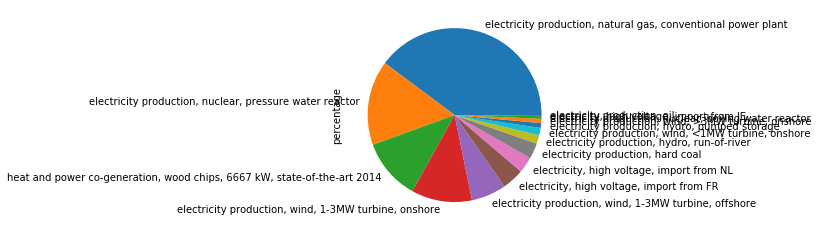

In [64]:
gb = elec_list[1]
gb_fm = FuturaMarket(gb, f.database)
gb_fm.plot

That's a lot more coal than you'd expect!

Next up, Germany:

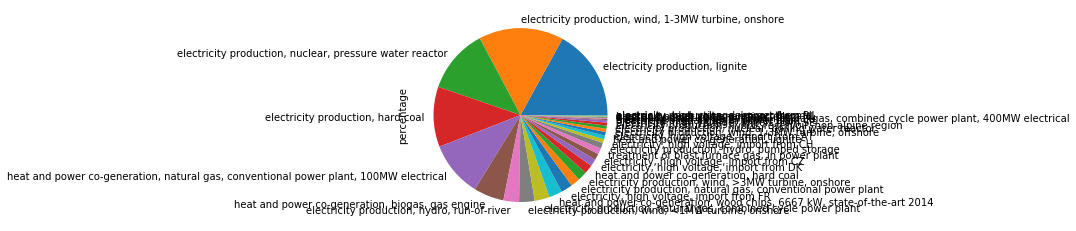

In [65]:
de = elec_list[0]
de_fm = FuturaMarket(de, f.database)
de_fm.plot

## Loading the IEA Importer

OK - let's load up the IEA Importer from the plugin. We give it our FuturaLoader so it can make the edits to the grids directly.

We'll get some warnings (from `country_converter`) about country codes not being found - this is to do with making sure the regions map correctly onto their ecoinvent counterparts and is nothing to worry about.

In [55]:
iea_converter = futura.iea.IEA_Importer(f)

root        : WARNING  OECDTOT not found in regex
root        : WARNING  OECDAM not found in regex
root        : WARNING  OECDAO not found in regex
root        : WARNING  OECDEUR not found in regex
root        : WARNING  IEATOT not found in regex
root        : WARNING  OECDTOT not found in regex
root        : WARNING  OECDTOT not found in regex
root        : WARNING  OECDAM not found in regex
root        : WARNING  OECDAM not found in regex
root        : WARNING  OECDAO not found in regex
root        : WARNING  OECDAO not found in regex
root        : WARNING  OECDEUR not found in regex
root        : WARNING  OECDEUR not found in regex
root        : WARNING  IEATOT not found in regex
root        : WARNING  IEATOT not found in regex
root        : WARNING  AUSTRALI not found in regex
root        : WARNING  NETHLAND not found in regex
root        : WARNING  SWITLAND not found in regex
root        : WARNING  UK not found in ISO2


Now all we need to do is run the `update_grid` function. We can either pass it a list of countries, or we can run it with no arguments to update all of the available grids.

In [56]:
iea_converter.update_grid(grid_locations)

Updated grid mix for Germany
Updated grid mix for United Kingdom


## Let's see what we've done
Ok - let's rerun our filter to grab the updated versions of the electricity markets from our FuturaLoader and see what they look like now

In [66]:
elec_list2 = list(w.get_many(f.database.db, *elec_filter))

First up, let's take a look at the IEA data for the UK - this is aggregated at a higher level than the ecoinvent data

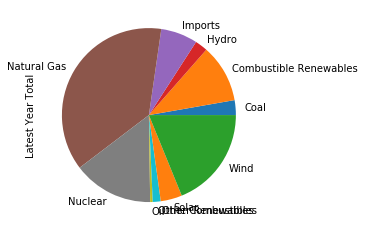

In [69]:
iea_converter.aggregated_data.loc['GB'].plot(kind='pie', y='Latest Year Total', legend=None)

When the IEA Importer does it's thing, it groups the available technologies in the existing market according to the classifications above. Then it reassigns the technologies to the new sections based on their percentage contribution to that technology group - this keeps the proportions of things like imports, and generation technologies in the same ratio, but with a different overall contribution

Here's what the UK looks like now:

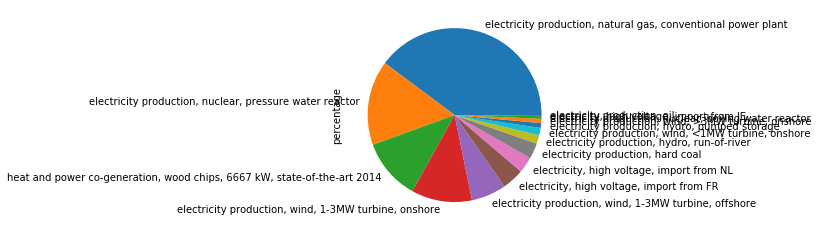

In [71]:
gb2 = elec_list2[1]
gb_fm2 = FuturaMarket(gb2, f.database)
gb_fm2.plot

That looks a lot better - Coal down to around 4%, mainly gas, some nuclear, a high proportion of wind - far more accurate.

Let's do the same for Germany, first here's what the IEA data says:

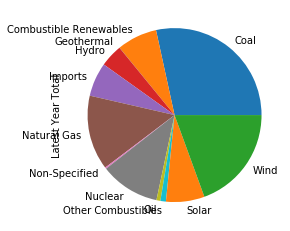

In [49]:
iea_converter.aggregated_data.loc['DE'].plot(kind='pie', y='Latest Year Total', legend=None)

And here is the new market mix:

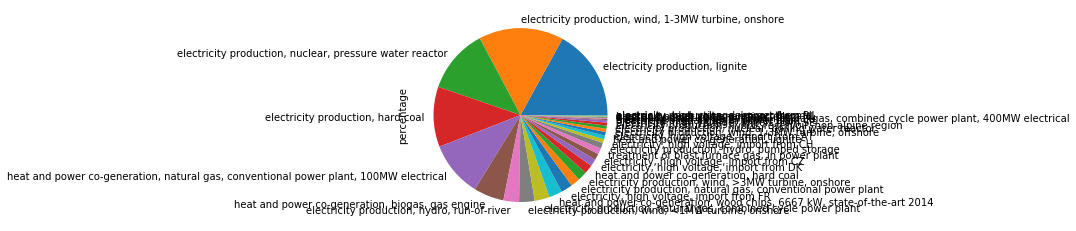

In [72]:
de2 = elec_list[0]
de_fm2 = FuturaMarket(de2, f.database)
de_fm2.plot

You can see that the **coal** section from the IEA pie chart is split between lignite and hard coal along the proportions of the original grid mix in Germany.

You can also see that whereas in the UK the **combustible renewables** section is mainly assigned to wood chips, in Germany is is mainly assigned to biogas - again based on the composition of the original market.

## What's next?
You can now write the updated version of the database to brightway using `f.write_database()` and see what effect it will have on your modelling